![Machine Learning for Scientists in a hurry](https://github.com/romerogroup/Notebooks_4SIAH/blob/main/Machine_Learning/fig/Title_ML.png?raw=1)

# Boilerplate

In [1]:
!if [ ! -f helpers.py ]; then wget "https://raw.githubusercontent.com/romerogroup/Notebooks_4SIAH/main/Machine_Learning/helpers.py"; fi

In [2]:
# import some custom helper code
import helpers
from helpers import set_css_in_cell_output
get_ipython().events.register('pre_run_cell', set_css_in_cell_output)

In [3]:
!pip install watermark tqdm

In [4]:
%%html
<div style="clear: both; display: table;" class="div-white">
  <div style="border: none; float: left; width: 60%; padding: 5px">
  <h1 id="subtitle">Chapter 8. Steel Strength predicted with Machine Learning</h1>
  <h2 id="subtitle">Guillermo Avendaño Franco<br>Aldo Humberto Romero</h2>
  <br>
  <img src="https://raw.githubusercontent.com/romerogroup/Notebooks_4SIAH/main/Machine_Learning/fig/1-line logotype124-295.png" alt="Scientific Computing with Python" style="width:50%" align="left">
  </div>
  <div style="border: none; float: left; width: 30%; padding: 5px">
  <img src="https://raw.githubusercontent.com/romerogroup/Notebooks_4SIAH/main/Machine_Learning/fig/SCPython.png" alt="Scientific Computing with Python" style="width:100%">
  </div>
</div>

<div style="clear: both; display: table;" class="div-white">
  <div style="border: none; float: left; width: 60%; padding: 5px">
  <h1 id="subtitle">Chapter 8. Steel Strength predicted with Machine Learning</h1>
  <h2 id="subtitle">Guillermo Avendaño Franco<br>Aldo Humberto Romero</h2>
  <br>
  <img src="https://raw.githubusercontent.com/romerogroup/Notebooks_4SIAH/main/Machine_Learning/fig/1-line logotype124-295.png" alt="Scientific Computing with Python" style="width:50%" align="left">
  </div>
  <div style="border: none; float: left; width: 30%; padding: 5px">
  <img src="https://raw.githubusercontent.com/romerogroup/Notebooks_4SIAH/main/Machine_Learning/fig/SCPython.png" alt="Scientific Computing with Python" style="width:100%">
  </div>
</div>

## Setup

In [5]:
%load_ext watermark

In [6]:
%watermark

Last updated: 2023-10-23T17:40:36.955363-04:00

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.14.0

Compiler    : Clang 11.0.3 (clang-1103.0.32.62)
OS          : Darwin
Release     : 19.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit



In [7]:
import time
start = time.time()
chapter_number = 1
import matplotlib
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt

In [37]:
import os
import requests
import numpy as np
import pandas as pd
import matplotlib as mpl
import sklearn
import random
import seaborn as sns

In [9]:
%watermark -iv

pandas    : 1.5.3
numpy     : 1.25.2
matplotlib: 3.8.0
sklearn   : 1.3.0
requests  : 2.31.0



# Mechanical properties of some steels

Steel is alloy of iron and carbon and some other atoms. To be considered steel the carbon content must be at most 2 percent (if the alloy contains a higher carbon content, the material is called cast iron). Steel is the most widely used metal for building.
Steel is used to fabricate from sewing needles to oil tankers. 

In 2013 the world’s raw steel production was about 1.6 billion tons, compare this figure with another metal, aluminum, the production of aluminum was about 47 million tons. 

There are several reasons for the popularity of steel. First, the base metal is Iron, which is the most abundant metal in the Universe. Iron currently accounts for approximately 0.11% of all matter in the universe. It is the sixth most common element overall and the most abundant metal.

| Z   | Element  | Mass fraction (ppm) |
|-----|----------|:--------------:|
| 1   | Hydrogen | 739   |
| 2   | Helium   | 240   |
| 8   | Oxygen   | 10    |
| 6   | Carbon   | 4.6   |
| 10  | Neon     | 1.34  |
| 26  | Iron     | 1.09  |

The most abundant iron isotope ${}^{56}\text{Fe}$ is of particular interest to nuclear scientists because it represents the most common endpoint of nucleosynthesis. As such it is considered most common refractory element.

In the solar system, Iron accounts for around 0.1% of the Sun and around 22% of meteorite material found on Earth. Iron makes up around 0.006% of a human being. Iron is essential for the chemical function of Hemoglobin, the iron-containing oxygen-transport protein present in erythrocytes (red blood cells) of almost all vertebrates.

From the industry point of view, Steel is also an ideal material.
It has a relatively low cost of making, forming, and processing it.
Relatively easy and abundant in mines or to reprocess from scrap.
From other side, steel has an unparalleled range of mechanical properties.

Our first step is to collect a table with properties of various steel compositions with variations in the carbon percentage and the amount of other atoms that can influence its mechanical properties.

We have two files to get the data, one is a CSV file and the other is a JSON file. Both formats are today very commonly used to store tabular or structured data. 

Our first task is to read those two files and we can use Pandas for that.

In [10]:
if not os.path.exists('data'):
    os,mkdir('data')

if os.path.exists('cache/steel_strength.csv'):
    df = pd.read_csv("cache/steel_strength.csv")
else:
    url = 'https://raw.githubusercontent.com/romerogroup/Notebooks_4SIAH/main/Machine_Learning/cache/steel_strength.csv'
    data = requests.get(url).content
    f = open('data/steel_strength.csv','wb')
    f.write(data)
    f.close()
    df = pd.read_csv("data/steel_strength.csv")

After reading the CSV file with pandas, we get the DataFrame `df` that follows a structure that is tipically found as the base of many machine learning projects.

Lets have a quick look to the dataframe

In [11]:
df

,formula,c,mn,si,cr,ni,mo,v,n,nb,co,w,al,ti,yield strength,tensile strength,elongation
0,Fe0.620C0.000953Mn0.000521Si0.00102Cr0.000110N...,0.02,0.05,0.05,0.01,19.70,2.95,0.01,0.00,0.01,15.00,0.00,0.15,1.55,2411.5,2473.5,7.0
1,Fe0.623C0.00854Mn0.000104Si0.000203Cr0.147Ni0....,0.18,0.01,0.01,13.44,0.01,3.01,0.46,0.04,0.01,19.46,2.35,0.04,0.00,1123.1,1929.2,8.0
2,Fe0.625Mn0.000102Si0.000200Cr0.0936Ni0.129Mo0....,0.00,0.01,0.01,8.67,13.45,0.82,0.01,0.00,0.01,13.90,0.00,0.39,0.57,1736.3,1871.8,NaN
3,Fe0.634C0.000478Mn0.000523Si0.00102Cr0.000111N...,0.01,0.05,0.05,0.01,17.70,3.95,0.01,0.00,0.01,15.00,0.00,0.13,1.47,2487.3,2514.9,9.0
4,Fe0.636C0.000474Mn0.000518Si0.00101Cr0.000109N...,0.01,0.05,0.05,0.01,19.40,1.45,0.01,0.00,0.01,14.90,0.00,0.13,1.55,2249.6,2315.0,8.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,Fe0.823C0.0176Mn0.00183Si0.000198Cr0.0779Ni0.0...,0.38,0.18,0.01,7.27,0.01,3.77,0.96,0.00,0.01,4.90,0.00,0.03,0.00,1722.5,1998.1,5.0
308,Fe0.823Mn0.000618Si0.00101Cr0.0561Ni0.0984Mo0....,0.00,0.06,0.05,5.15,10.20,3.20,0.01,0.00,0.01,0.01,0.00,0.03,0.09,1019.0,1019.0,19.0
309,Fe0.825C0.0174Mn0.00175Si0.000201Cr0.0565Ni0.0...,0.37,0.17,0.01,5.20,0.01,5.84,1.05,0.00,0.91,4.88,0.00,0.03,0.00,1860.3,2156.6,3.0
310,Fe0.858C0.0191Mn0.00194Si0.000199Cr0.0753Ni0.0...,0.41,0.19,0.01,6.99,0.01,5.84,0.92,0.00,0.01,0.02,0.00,0.03,0.00,1812.1,2087.7,2.0


We see 312 rows, those are the entries, having more entries is fundamental for the success of machine learning models. A good set of entries explores widely the configuration space of our problem.

We have also 17 columns, the first column is "formula" which is some sort of label for the entries. We will not use much this column so we end up with 16 columns with actual numerical values.

From those 16 we have 13 that correspond to the composition of steels: `c` 	`mn` 	`si` 	`cr` 	`ni` 	`mo` 	`v` 	`n` 	`nb` 	`co` 	`w` 	`al` 	`ti`. We can consider these columns as inputs for the models we will use.

The last 3 columns are our target features: `yield strength` 	`tensile strength` 	`elongation`. Our purpose will be to try to predict these features from the composition of the steel.

We can transpose the dataframe to present for example the first two entries in two columns:

In [12]:
display(df[0:2].T)

,0,1
formula,Fe0.620C0.000953Mn0.000521Si0.00102Cr0.000110N...,Fe0.623C0.00854Mn0.000104Si0.000203Cr0.147Ni0....
c,0.02,0.18
mn,0.05,0.01
si,0.05,0.01
cr,0.01,13.44
ni,19.7,0.01
mo,2.95,3.01
v,0.01,0.46
n,0.0,0.04
nb,0.01,0.01


There are two functions that are important to use to get a big picture from the data. One is `pandas.DataFrame.info` and the other `pandas.DataFrame.describe`. These methods will help us identify the structure and data types of the different columns.

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312 entries, 0 to 311
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   formula           312 non-null    object 
 1   c                 312 non-null    float64
 2   mn                312 non-null    float64
 3   si                312 non-null    float64
 4   cr                312 non-null    float64
 5   ni                312 non-null    float64
 6   mo                312 non-null    float64
 7   v                 312 non-null    float64
 8   n                 312 non-null    float64
 9   nb                312 non-null    float64
 10  co                312 non-null    float64
 11  w                 312 non-null    float64
 12  al                312 non-null    float64
 13  ti                312 non-null    float64
 14  yield strength    312 non-null    float64
 15  tensile strength  312 non-null    float64
 16  elongation        303 non-null    float64
dt

In [14]:
df.describe()

,c,mn,si,cr,ni,mo,v,n,nb,co,w,al,ti,yield strength,tensile strength,elongation
count,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,303.000000
mean,0.096442,0.146250,0.221218,8.043830,8.184006,2.766090,0.183750,0.005545,0.035449,7.008782,0.161282,0.239135,0.310897,1420.998397,1641.653205,14.007261
std,0.109008,0.397102,0.580796,5.426169,6.337055,1.832908,0.452462,0.018331,0.161537,6.254431,0.920211,0.340110,0.556593,301.894169,346.475179,5.095974
min,0.000000,0.010000,0.010000,0.010000,0.010000,0.020000,0.000000,0.000000,0.000000,0.010000,0.000000,0.010000,0.000000,1005.900000,1019.000000,2.000000
25%,0.010000,0.010000,0.010000,3.100000,0.960000,1.500000,0.010000,0.000000,0.010000,0.010000,0.000000,0.030000,0.000000,1219.475000,1338.125000,10.800000
50%,0.030000,0.010000,0.010000,9.050000,8.500000,2.210000,0.010000,0.000000,0.010000,7.085000,0.000000,0.050000,0.030000,1344.200000,1666.300000,14.800000
75%,0.182500,0.080000,0.110000,12.520000,12.117500,4.090000,0.127500,0.000000,0.010000,13.480000,0.000000,0.300000,0.232500,1576.075000,1899.950000,17.300000
max,0.430000,3.000000,4.750000,17.500000,21.000000,9.670000,4.320000,0.150000,2.500000,20.100000,9.180000,1.800000,2.500000,2510.300000,2570.000000,35.000000


So far, we are very lucky. Most of the entries are filled. We 312 values for each column except for `elongation` which only has 303 values. In many situations data is far less clean, and we have to remove or fill the values of some entries to account for missing values.

This is a very good table, we can however, get rid of the first column that we will not use and check for duplicate entries which in this particular case we do not have.

The function `sklearn.preprocessing.LabelEncoder` encode target labels with value between 0 and n_classes-1. In our case, this is not needed but the code below could be used in other cases.

In [15]:
from sklearn.preprocessing import LabelEncoder

def labelencoder(df):
    for c in df.columns:
        if df[c].dtype=='object':
            print(c)
            df[c] = df[c].fillna('N')
            lbl = LabelEncoder()
            lbl.fit(list(df[c].values))
            df[c] = lbl.transform(df[c].values)
    return df

For us, we will just remove the first column to create a new dataframe `df1`

In [16]:
df1=labelencoder(df.iloc[:,1:])

We know that there are some missing values for elongation, lets check those:

In [17]:
df1['elongation'].isnull().values.any()

True

In [18]:
df['elongation'].isnull().values.sum()

9

This is the table of entries with missing value for `elongation` 

In [19]:
df1[df1['elongation'].isnull()]

,c,mn,si,cr,ni,mo,v,n,nb,co,w,al,ti,yield strength,tensile strength,elongation
2,0.00,0.01,0.01,8.67,13.45,0.82,0.01,0.0,0.01,13.90,0.00,0.39,0.57,1736.3,1871.8,NaN
58,0.01,0.01,0.01,8.14,11.95,0.02,0.01,0.0,0.01,10.48,0.00,0.39,1.11,1768.0,1828.6,NaN
61,0.00,0.01,0.01,11.85,10.25,1.47,0.01,0.0,0.01,7.48,0.00,0.43,0.56,1586.7,1671.3,NaN
79,0.01,0.01,0.01,8.84,10.81,1.19,0.41,0.0,0.01,9.24,0.00,0.43,0.57,1755.2,1820.7,NaN
83,0.01,0.01,0.01,7.74,11.91,0.98,0.01,0.0,0.01,9.95,0.00,0.27,0.71,1779.7,1856.2,NaN
85,0.35,0.01,0.01,9.00,1.50,2.00,0.30,0.0,0.01,18.00,0.00,0.03,0.02,1731.7,2232.4,NaN
86,0.00,0.01,0.01,11.11,10.00,1.23,0.01,0.0,0.01,7.51,0.28,0.57,0.59,1729.4,1817.2,NaN
112,0.00,0.01,0.01,14.30,8.30,2.60,0.01,0.0,0.01,4.30,0.00,0.10,0.49,1350.4,1478.0,NaN
113,0.00,0.01,0.01,14.30,8.40,2.50,0.01,0.0,0.01,4.30,0.00,0.12,0.47,1274.7,1347.0,NaN


# Visualizing the data

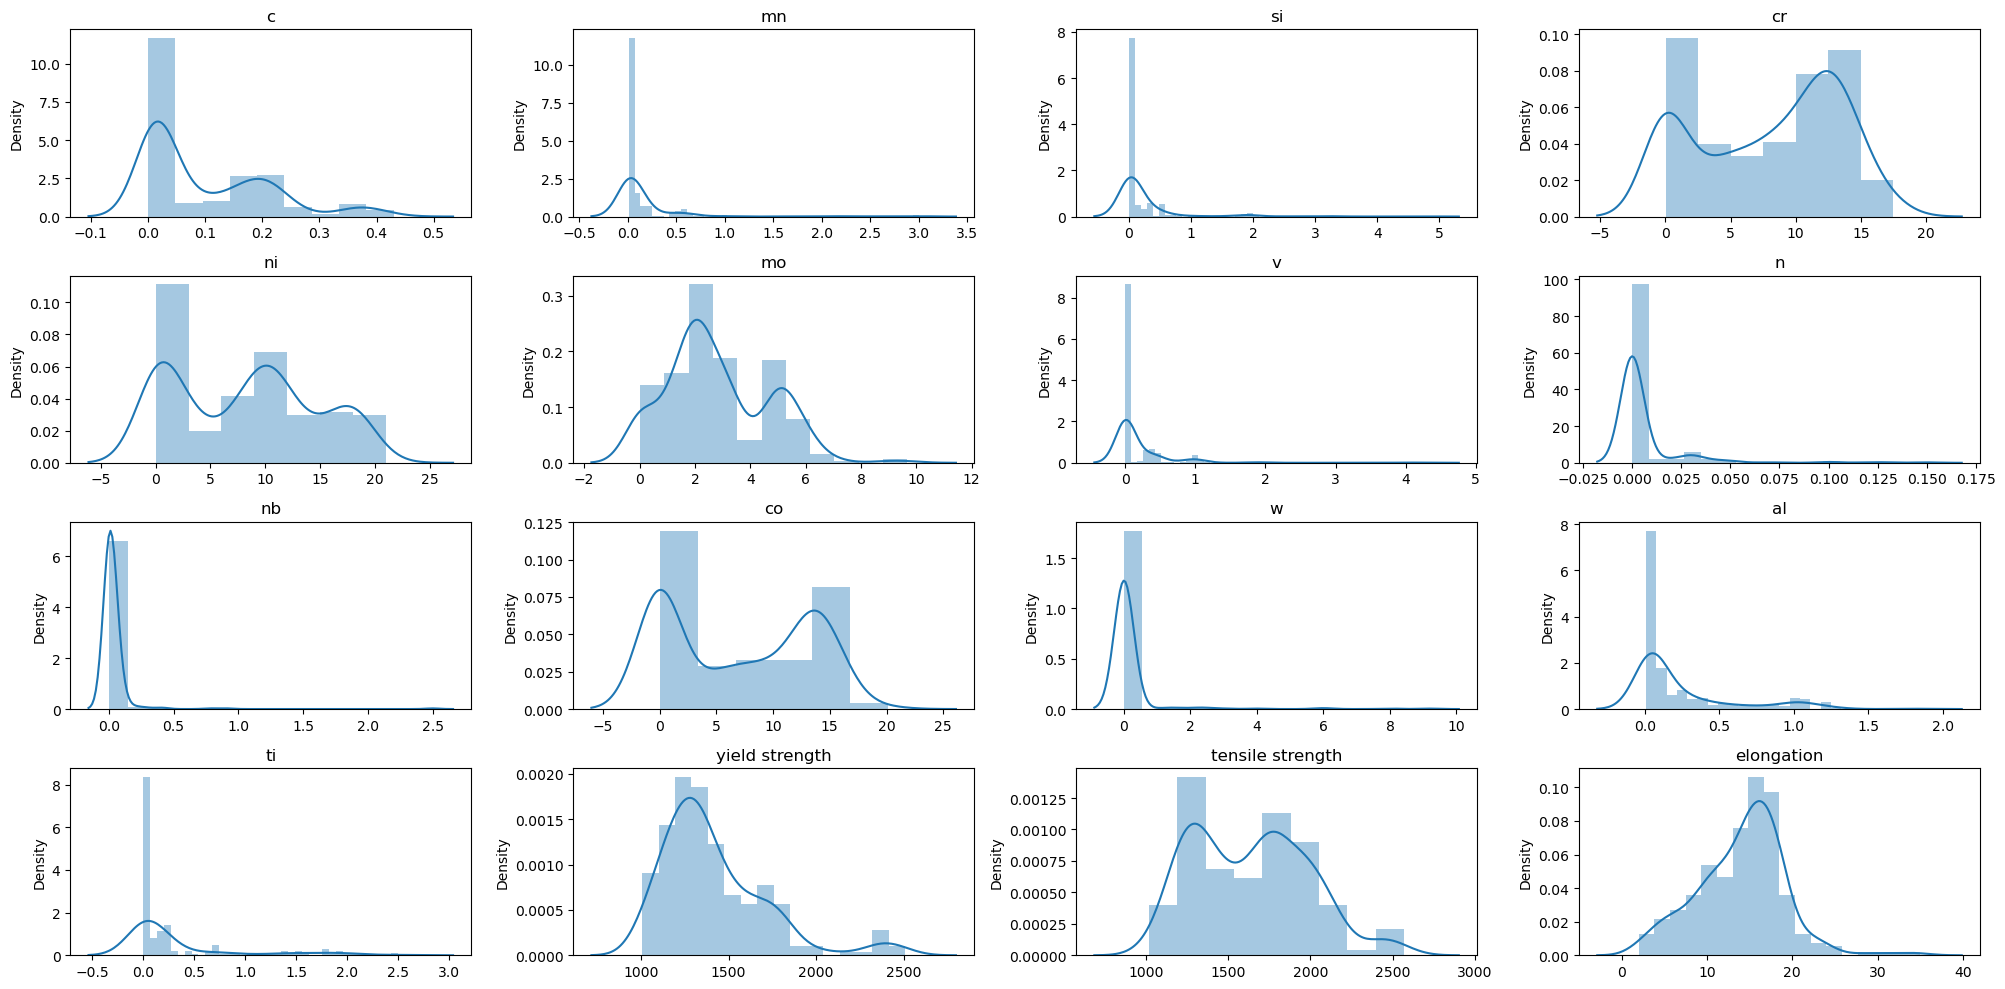

In [41]:
dn = df1[~df1.isin([np.nan, np.inf, -np.inf]).any(1)]

col=list(df1.columns)
fig = plt.figure(figsize=(20,10))

for i in range(len(col)):
    plt.subplot(4,4,i+1)
    plt.title(col[i])
    sns.distplot(dn,x=dn[col[i]])
    
plt.tight_layout()
plt.show()

# Input and target columns 

Our next step is to separate the input columns from the the target columns.

In [20]:
target=['yield strength','tensile strength']
dfY=df1[target]
dfX=df1.drop(target+['elongation'],axis=1)

In [21]:
dfX

,c,mn,si,cr,ni,mo,v,n,nb,co,w,al,ti
0,0.02,0.05,0.05,0.01,19.70,2.95,0.01,0.00,0.01,15.00,0.00,0.15,1.55
1,0.18,0.01,0.01,13.44,0.01,3.01,0.46,0.04,0.01,19.46,2.35,0.04,0.00
2,0.00,0.01,0.01,8.67,13.45,0.82,0.01,0.00,0.01,13.90,0.00,0.39,0.57
3,0.01,0.05,0.05,0.01,17.70,3.95,0.01,0.00,0.01,15.00,0.00,0.13,1.47
4,0.01,0.05,0.05,0.01,19.40,1.45,0.01,0.00,0.01,14.90,0.00,0.13,1.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,0.38,0.18,0.01,7.27,0.01,3.77,0.96,0.00,0.01,4.90,0.00,0.03,0.00
308,0.00,0.06,0.05,5.15,10.20,3.20,0.01,0.00,0.01,0.01,0.00,0.03,0.09
309,0.37,0.17,0.01,5.20,0.01,5.84,1.05,0.00,0.91,4.88,0.00,0.03,0.00
310,0.41,0.19,0.01,6.99,0.01,5.84,0.92,0.00,0.01,0.02,0.00,0.03,0.00


In [22]:
dfY

,yield strength,tensile strength
0,2411.5,2473.5
1,1123.1,1929.2
2,1736.3,1871.8
3,2487.3,2514.9
4,2249.6,2315.0
...,...,...
307,1722.5,1998.1
308,1019.0,1019.0
309,1860.3,2156.6
310,1812.1,2087.7


In [23]:
list(dfX.columns)

['c', 'mn', 'si', 'cr', 'ni', 'mo', 'v', 'n', 'nb', 'co', 'w', 'al', 'ti']

In [24]:
m=len(dfX)
m

312

# Creating a Training and Test sets`

In [25]:
df_columns = list(dfX.columns)
print(df_columns)

['c', 'mn', 'si', 'cr', 'ni', 'mo', 'v', 'n', 'nb', 'co', 'w', 'al', 'ti']


In [26]:
M=list(range(m))
random.seed(2021)
random.shuffle(M)

In [27]:
trainX=dfX.iloc[M[0:(m//4)*3]]
trainY=dfY.iloc[M[0:(m//4)*3]]
testX=dfX.iloc[M[(m//4)*3:]]
testY=dfY.iloc[M[(m//4)*3:]]

In [28]:
train_df=trainX
test_df=testX

In [29]:
train_df.columns=df_columns
test_df.columns=df_columns

# Context Manager

In [30]:
from contextlib import contextmanager
from time import time

df_columns = list(dfX.columns)

def create_numeric_feature(input_df):
    use_columns = df_columns 
    return input_df[use_columns].copy()

class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

# Adding a smart progress meter

In [31]:
from tqdm import tqdm

def to_feature(input_df):

    processors = [
        create_numeric_feature,
    ]
    
    out_df = pd.DataFrame()
    
    for func in tqdm(processors, total=len(processors)):
        with Timer(prefix='function: ' + func.__name__ + ' '):
            _df = func(input_df)

        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)
        
    return out_df

In [32]:
train_feat_df = to_feature(trainX)
test_feat_df = to_feature(testX)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 226.24it/s]


function: create_numeric_feature  0.002[s]


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 462.79it/s]

function: create_numeric_feature  0.001[s]


In [33]:
train_feat_df

,c,mn,si,cr,ni,mo,v,n,nb,co,w,al,ti
236,0.03,0.05,0.11,7.50,12.10,3.05,0.01,0.00,0.01,0.01,0.0,0.25,0.20
255,0.01,0.05,0.09,7.60,10.30,3.05,0.01,0.00,0.01,0.01,0.0,0.52,0.20
18,0.01,0.01,0.01,0.01,15.00,6.02,0.01,0.00,0.01,14.80,0.0,0.03,0.62
132,0.03,0.01,0.01,0.01,18.30,5.10,0.01,0.00,0.01,6.70,0.0,0.11,0.70
258,0.01,0.03,0.01,0.01,18.11,3.07,0.01,0.00,0.01,0.01,0.0,0.09,1.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,0.01,0.05,0.06,5.32,12.95,2.93,0.01,0.00,0.01,0.01,0.0,0.51,0.20
72,0.15,0.01,0.01,14.36,0.01,3.04,0.41,0.03,0.01,13.64,0.0,0.03,0.00
121,0.23,0.01,0.36,12.60,0.95,1.97,0.01,0.00,0.08,12.77,0.0,0.03,0.00
177,0.03,0.01,0.01,12.64,8.44,2.24,0.01,0.00,0.01,0.01,0.0,1.31,0.01


In [34]:
import lightgbm as lgbm
from sklearn.metrics import mean_squared_error

def fit_lgbm(X, y, cv, 
             params: dict=None, 
             verbose: int=50):

    if params is None:
        params = {}

    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMRegressor(**params)
        
        with Timer(prefix='fit fold={} '.format(i)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=100,
                    verbose=verbose)

        pred_i = clf.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        print(f'Fold {i} RMSLE: {mean_squared_error(y_valid, pred_i) ** .5:.4f}')
        print()

    score = mean_squared_error(y, oof_pred) ** .5
    print('-' * 50)
    print('FINISHED | Whole RMSLE: {:.4f}'.format(score))
    return oof_pred, models

OSError: dlopen(/Users/guilleaf/Library/Python/3.11/lib/python/site-packages/lightgbm/lib/lib_lightgbm.so, 6): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib
  Referenced from: /Users/guilleaf/Library/Python/3.11/lib/python/site-packages/lightgbm/lib/lib_lightgbm.so
  Reason: image not found